In [1]:
import numpy as np
import glob, os, re, sys
from pathlib import Path
sys.path.append('../')

import pandas as pd
import polars as pl
from scipy.stats import binned_statistic

import astro_helper as ah
import configparser
config = configparser.ConfigParser()
config.read('../config_allgas.ini')

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as patches
from matplotlib import rc
rc('axes', linewidth=1.5)
rc('axes', edgecolor='#3C3C3C')
plt.style.use('mpl_style_Jeffreson.mplstyle')
custom_colors = {
    'grey': '#3C3C3C',
    'turquoise': '#5E9F87'
}

In [2]:
tags = ['ETG-vlM', 'ETG-lowM', 'ETG-medM', 'ETG-hiM', 'MW']
tagdirs = [Path(config[tag]['SAVE_DIR']) / Path(config[tag]['SUBDIR']) for tag in tags]
xymaxs = [config[tag].getfloat('XYMAX') for tag in tags] # kpc
xybinwidths = [config[tag].getfloat('XYBINWIDTH') for tag in tags] # pc
xybinnos = [int(np.rint(2.*xymax * ah.kpc_to_cm / (xybinwidth * ah.pc_to_cm))) for xymax, xybinwidth in zip(xymaxs, xybinwidths)]

# real weight

In [3]:
df = pl.read_parquet('/n/holystore01/LABS/itc_lab/Users/sjeffreson/GalactISM/GalactISM.parquet').to_pandas()

In [24]:
# separate by galaxy
weights_gal, veldisps_gal, Rs_gal = [], [], []
for tag, xymax in zip(tags, xymaxs):
    mask = df['galaxy'] == tag
    #Ptot = np.array(df.loc[mask, 'Pturb']) + np.array(df.loc[mask, 'Ptherm'])
    #Pturb = np.array(df.loc[mask, 'Pturb'])
    #Ptot[Pturb <= 0.] = 0.
    #Ptot = pd.Series(Ptot, index=df.loc[mask].index)
    #weights_gal.append(Ptot)
    weights_gal.append(df.loc[mask, 'weight'])
    veldisps_gal.append(df.loc[mask, 'veldisp_midplane'])
    Rs_gal.append(df.loc[mask, 'R/Router'] * xymax)

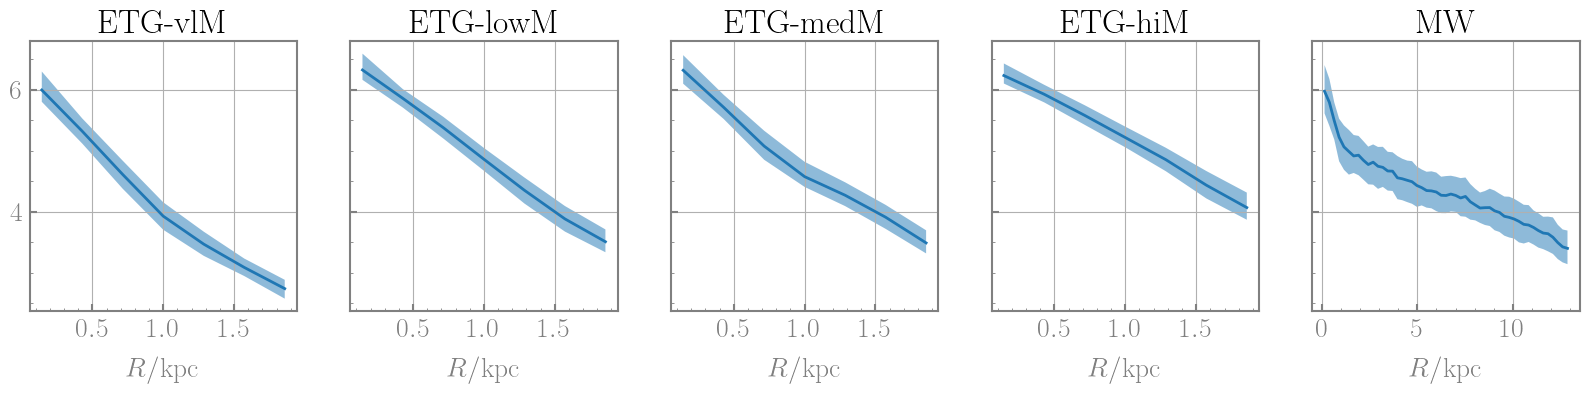

In [25]:
# plot the median weight as a function of R on a separate axis for each galaxy
fig, axs = plt.subplots(1, len(tags), figsize=(4*len(tags), 3.5), sharey=True)
for ax, tag, weights, Rs, xymax in zip(axs, tags, weights_gal, Rs_gal, xymaxs):
    bins = np.linspace(0., xymax, int(np.rint(xymax/0.25)))
    Rbins = 0.5*(bins[:-1] + bins[1:])
    cnd = weights > 0.
    weights_med, _, _ = binned_statistic(Rs[cnd], weights[cnd], bins=bins, statistic='median')
    weights_q1, _, _ = binned_statistic(Rs[cnd], weights[cnd], bins=bins, statistic=lambda x: np.percentile(x, 25))
    weights_q4, _, _ = binned_statistic(Rs[cnd], weights[cnd], bins=bins, statistic=lambda x: np.percentile(x, 75))
    ax.plot(Rbins, np.log10(weights_med), lw=2)
    ax.fill_between(Rbins, np.log10(weights_q1), np.log10(weights_q4), alpha=0.5)
    ax.set_xlabel(r'$R/{\rm kpc}$')
    ax.set_title(tag)
    ax.tick_params(axis='both', direction='in', which='both')
    ax.minorticks_on()
    ax.grid(True)
plt.show()

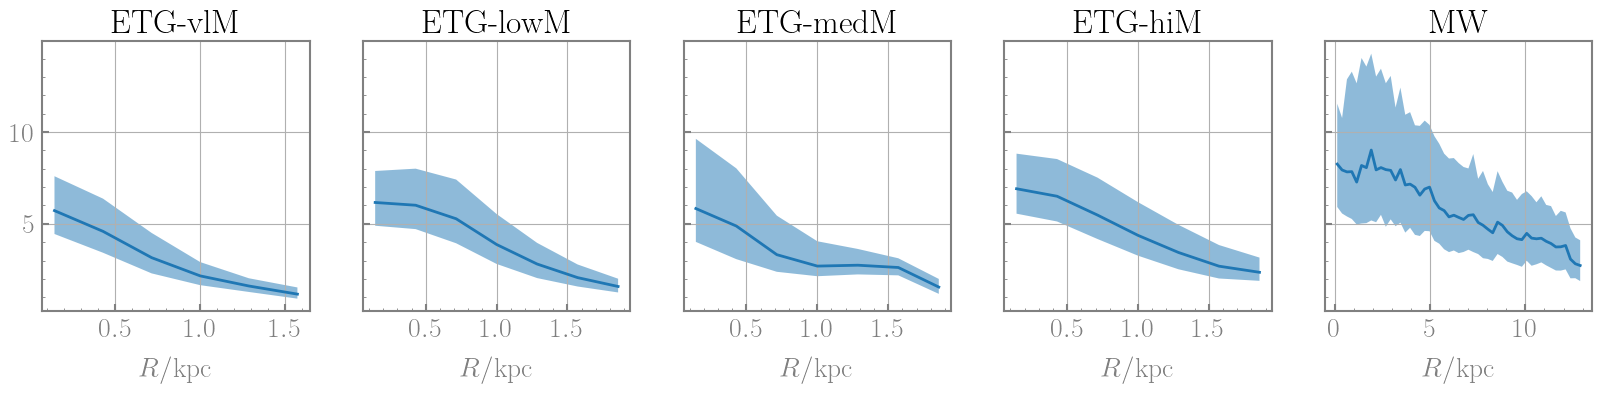

In [26]:
# suppress divide by zero warnings
np.seterr(divide='ignore', invalid='ignore')
fig, axs = plt.subplots(1, len(tags), figsize=(4*len(tags), 3.5), sharey=True)
for ax, tag, veldisp, Rs, xymax in zip(axs, tags, veldisps_gal, Rs_gal, xymaxs):
    cnd = (veldisp>0) # can only compare where we have resolved mid-plane gas
    bins = np.linspace(0., xymax, int(np.rint(xymax/0.25)))
    Rbins = 0.5*(bins[:-1] + bins[1:])
    veldisps_med, _, _ = binned_statistic(Rs[cnd], veldisp[cnd], bins=bins, statistic='median')
    veldisps_q1, _, _ = binned_statistic(Rs[cnd], veldisp[cnd], bins=bins, statistic=lambda x: np.percentile(x, 25))
    veldisps_q4, _, _ = binned_statistic(Rs[cnd], veldisp[cnd], bins=bins, statistic=lambda x: np.percentile(x, 75))
    ax.plot(Rbins, veldisps_med/1.e5, lw=2)
    ax.fill_between(Rbins, veldisps_q1/1.e5, veldisps_q4/1.e5, alpha=0.5)
    ax.set_xlabel(r'$R/{\rm kpc}$')
    ax.set_title(tag)
    ax.tick_params(axis='both', direction='in', which='both')
    ax.minorticks_on()
    ax.grid(True)
plt.show()

# geometric fitting weight

In [27]:
# separate by galaxy
weights_geom_gal, weights_bulgegeom_gal, sigmaEffs_geom_gal, sigmaEffs_bulgegeom_gal = [], [], [], []
for tag, xymax in zip(tags, xymaxs):
    mask = df['galaxy'] == tag
    SigmaGas = df.loc[mask, 'gas_surfdens']
    SigmaStars = df.loc[mask, 'star_surfdens']
    vcs = df.loc[mask, 'rotcurve']
    Rs = df.loc[mask, 'R/Router'] * xymax
    rhodms = df.loc[mask, 'dm_voldens']
    rhostars = df.loc[mask, 'star_voldens']
    Omegas2 = vcs**2/(Rs*ah.kpc_to_cm)**2#4. * np.pi * ah.G_cgs * rhodms
    Omegastars2 = vcs**2/(Rs*ah.kpc_to_cm)**2#4. * np.pi * ah.G_cgs * rhostars

    # disk geometry (weight dominated by disk, sets scale-height)
    i = 0
    sigmaEffs = 12.e5*np.ones(len(Rs)) # initialize, cm/s
    while i < 10:
        i += 1
        Sigma_sg = SigmaGas + SigmaStars
        weights_geom = SigmaGas / 4. * (
            np.pi * ah.G_cgs * Sigma_sg
            + np.sqrt((np.pi * ah.G_cgs * Sigma_sg)**2 + 8./3. * Omegas2 * sigmaEffs**2)
        )/ah.kB_cgs
        sigmaEffs = 12.e5 * (weights_geom/1.e4)**0.22

    weights_geom_gal.append(weights_geom)
    sigmaEffs_geom_gal.append(sigmaEffs)

    # bulge geometry (weight dominated by bulge, sets scale-height)
    i = 0
    sigmaEffs_bulgegeom = 12.e5*np.ones(len(Rs)) # initialize, cm/s
    while i < 10:
        i += 1
        weights_bulgegeom = (
            np.pi * ah.G_cgs * SigmaGas**2 / 2.
            + np.sqrt(1./6.) * SigmaGas * sigmaEffs_bulgegeom * np.sqrt(Omegastars2/3. + Omegas2)
        )/ah.kB_cgs
        sigmaEffs_bulgegeom = 12.e5 * (weights_bulgegeom/1.e4)**0.22

    weights_bulgegeom_gal.append(weights_bulgegeom)
    sigmaEffs_bulgegeom_gal.append(sigmaEffs_bulgegeom)

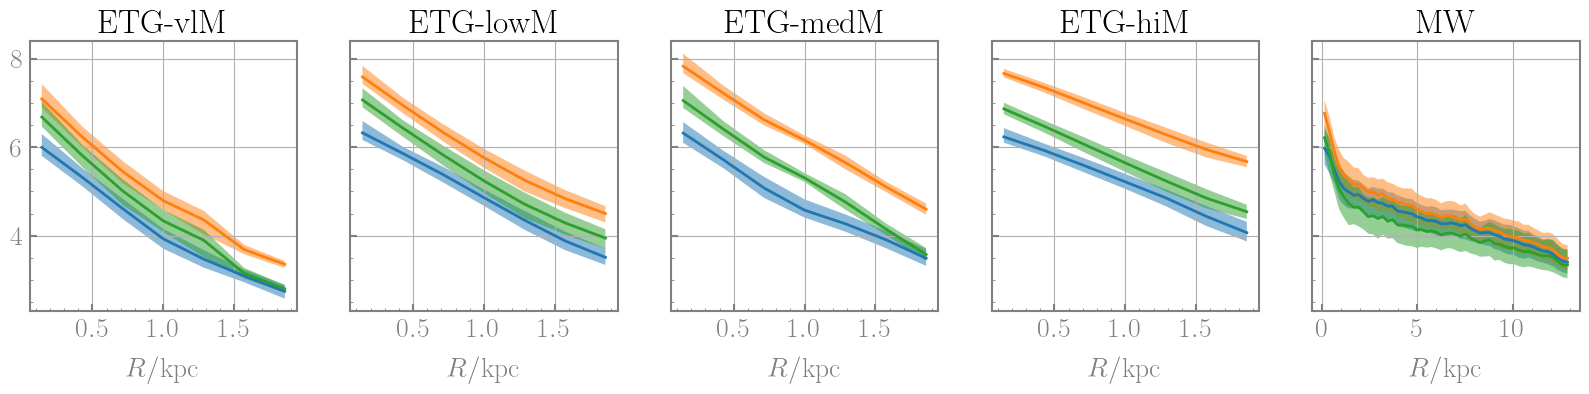

In [28]:
# plot the median weight as a function of R on a separate axis for each galaxy
fig, axs = plt.subplots(1, len(tags), figsize=(4*len(tags), 3.5), sharey=True)
for ax, tag, weights, weights_geom, weights_bulgegeom, Rs, xymax in zip(
    axs, tags, weights_gal, weights_geom_gal, weights_bulgegeom_gal, Rs_gal, xymaxs):
    bins = np.linspace(0., xymax, int(np.rint(xymax/0.25)))
    Rbins = 0.5*(bins[:-1] + bins[1:])
    cnd = weights > 0.
    weights_med, _, _ = binned_statistic(Rs[cnd], weights[cnd], bins=bins, statistic='median')
    weights_q1, _, _ = binned_statistic(Rs[cnd], weights[cnd], bins=bins, statistic=lambda x: np.percentile(x, 25))
    weights_q4, _, _ = binned_statistic(Rs[cnd], weights[cnd], bins=bins, statistic=lambda x: np.percentile(x, 75))
    weights_geom_med_, _, _ = binned_statistic(Rs[cnd], weights_geom[cnd], bins=bins, statistic='median')
    weights_geom_q1_, _, _ = binned_statistic(Rs[cnd], weights_geom[cnd], bins=bins, statistic=lambda x: np.percentile(x, 25))
    weights_geom_q4_, _, _ = binned_statistic(Rs[cnd], weights_geom[cnd], bins=bins, statistic=lambda x: np.percentile(x, 75))
    weights_bulgegeom_med_, _, _ = binned_statistic(Rs[cnd], weights_bulgegeom[cnd], bins=bins, statistic='median')
    weights_bulgegeom_q1_, _, _ = binned_statistic(Rs[cnd], weights_bulgegeom[cnd], bins=bins, statistic=lambda x: np.percentile(x, 25))
    weights_bulgegeom_q4_, _, _ = binned_statistic(Rs[cnd], weights_bulgegeom[cnd], bins=bins, statistic=lambda x: np.percentile(x, 75))
    
    ax.plot(Rbins, np.log10(weights_med), lw=2)
    ax.fill_between(Rbins, np.log10(weights_q1), np.log10(weights_q4), alpha=0.5)

    ax.plot(Rbins, np.log10(weights_geom_med_), lw=2)
    ax.fill_between(Rbins, np.log10(weights_geom_q1_), np.log10(weights_geom_q4_), alpha=0.5)

    ax.plot(Rbins, np.log10(weights_bulgegeom_med_), lw=2)
    ax.fill_between(Rbins, np.log10(weights_bulgegeom_q1_), np.log10(weights_bulgegeom_q4_), alpha=0.5)

    ax.set_xlabel(r'$R/{\rm kpc}$')
    ax.set_title(tag)
    ax.tick_params(axis='both', direction='in', which='both')
    ax.minorticks_on()
    ax.grid(True)
plt.show()

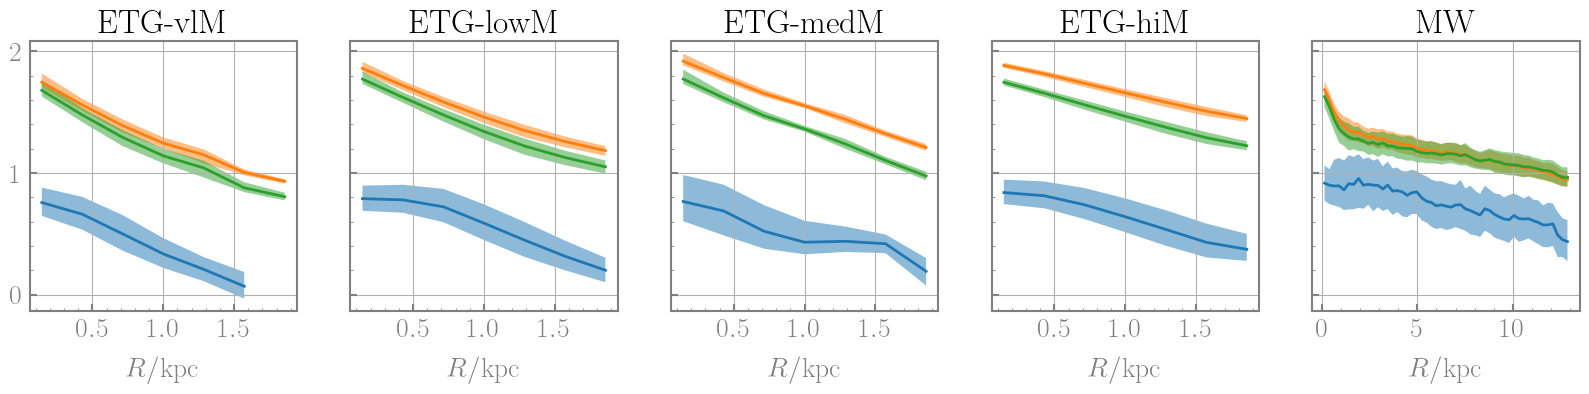

In [30]:
fig, axs = plt.subplots(1, len(tags), figsize=(4*len(tags), 3.5), sharey=True)
for ax, tag, veldisps, sigmaEffs_geom, sigmaEffs_bulgegeom, Rs, xymax in zip(
    axs, tags, veldisps_gal, sigmaEffs_geom_gal, sigmaEffs_bulgegeom_gal, Rs_gal, xymaxs):
    cnd = (veldisps>0) # just check where the cool-warm gas is
    bins = np.linspace(0., xymax, int(np.rint(xymax/0.25)))
    Rbins = 0.5*(bins[:-1] + bins[1:])
    veldisps_med, _, _ = binned_statistic(Rs[cnd], veldisps[cnd], bins=bins, statistic='median')
    veldisps_q1, _, _ = binned_statistic(Rs[cnd], veldisps[cnd], bins=bins, statistic=lambda x: np.percentile(x, 25))
    veldisps_q4, _, _ = binned_statistic(Rs[cnd], veldisps[cnd], bins=bins, statistic=lambda x: np.percentile(x, 75))
    sigmaEffs_med, _, _ = binned_statistic(Rs, sigmaEffs_geom, bins=bins, statistic='median')
    sigmaEffs_q1, _, _ = binned_statistic(Rs, sigmaEffs_geom, bins=bins, statistic=lambda x: np.percentile(x, 25))
    sigmaEffs_q4, _, _ = binned_statistic(Rs, sigmaEffs_geom, bins=bins, statistic=lambda x: np.percentile(x, 75))
    sigmaEffs_med_bulge, _, _ = binned_statistic(Rs, sigmaEffs_bulgegeom, bins=bins, statistic='median')
    sigmaEffs_q1_bulge, _, _ = binned_statistic(Rs, sigmaEffs_bulgegeom, bins=bins, statistic=lambda x: np.percentile(x, 25))
    sigmaEffs_q4_bulge, _, _ = binned_statistic(Rs, sigmaEffs_bulgegeom, bins=bins, statistic=lambda x: np.percentile(x, 75))

    ax.plot(Rbins, np.log10(veldisps_med/1.e5), lw=2)
    ax.fill_between(Rbins, np.log10(veldisps_q1/1.e5), np.log10(veldisps_q4/1.e5), alpha=0.5)

    ax.plot(Rbins, np.log10(sigmaEffs_med/1.e5), lw=2)
    ax.fill_between(Rbins, np.log10(sigmaEffs_q1/1.e5), np.log10(sigmaEffs_q4/1.e5), alpha=0.5)

    ax.plot(Rbins, np.log10(sigmaEffs_med_bulge/1.e5), lw=2)
    ax.fill_between(Rbins, np.log10(sigmaEffs_q1_bulge/1.e5), np.log10(sigmaEffs_q4_bulge/1.e5), alpha=0.5)

    ax.set_xlabel(r'$R/{\rm kpc}$')
    ax.set_title(tag)
    ax.tick_params(axis='both', direction='in', which='both')
    ax.minorticks_on()
    ax.grid(True)
plt.show()

# ML fitting weight

In [16]:
weights_MLP_gal, veldisps_MLP_gal, Rs_MLP_gal = [], [], []
for tag, xymax in zip(tags, xymaxs):
    df = pl.read_parquet('/n/holystore01/LABS/itc_lab/Users/sjeffreson/GalactISM/GalactISM_'+tag+'_pred.parquet').to_pandas()
    weights_MLP_gal.append(df['Ptot'])
    veldisps_MLP_gal.append(df['veldisp_midplane'])
    Rs_MLP_gal.append(df['R/Router'] * xymax)

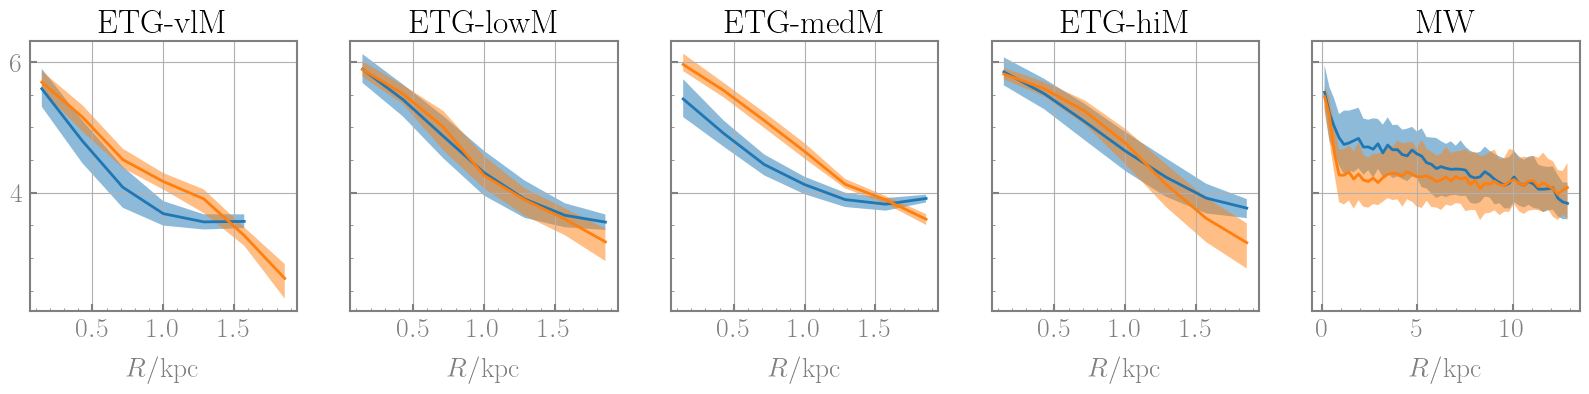

In [17]:
fig, axs = plt.subplots(1, len(tags), figsize=(4*len(tags), 3.5), sharey=True)
for ax, tag, weights, weights_MLP, Rs, Rs_MLP, xymax in zip(axs, tags, weights_gal, weights_MLP_gal, Rs_gal, Rs_MLP_gal, xymaxs):
    bins = np.linspace(0., xymax, int(np.rint(xymax/0.25)))
    Rbins = 0.5*(bins[:-1] + bins[1:])
    cnd = weights > 0.
    weights_med, _, _ = binned_statistic(Rs[cnd], weights[cnd], bins=bins, statistic='median')
    weights_q1, _, _ = binned_statistic(Rs[cnd], weights[cnd], bins=bins, statistic=lambda x: np.percentile(x, 25))
    weights_q4, _, _ = binned_statistic(Rs[cnd], weights[cnd], bins=bins, statistic=lambda x: np.percentile(x, 75))

    cnd = (weights_MLP>0)
    weights_MLP_med, _, _ = binned_statistic(Rs_MLP[cnd], weights_MLP[cnd], bins=bins, statistic='median')
    weights_MLP_q1, _, _ = binned_statistic(Rs_MLP[cnd], weights_MLP[cnd], bins=bins, statistic=lambda x: np.percentile(x, 25))
    weights_MLP_q4, _, _ = binned_statistic(Rs_MLP[cnd], weights_MLP[cnd], bins=bins, statistic=lambda x: np.percentile(x, 75))

    ax.plot(Rbins, np.log10(weights_med), lw=2)
    ax.fill_between(Rbins, np.log10(weights_q1), np.log10(weights_q4), alpha=0.5)

    ax.plot(Rbins, np.log10(weights_MLP_med), lw=2)
    ax.fill_between(Rbins, np.log10(weights_MLP_q1), np.log10(weights_MLP_q4), alpha=0.5)
    
    ax.set_xlabel(r'$R/{\rm kpc}$')
    ax.set_title(tag)
    ax.tick_params(axis='both', direction='in', which='both')
    ax.minorticks_on()
    ax.grid(True)

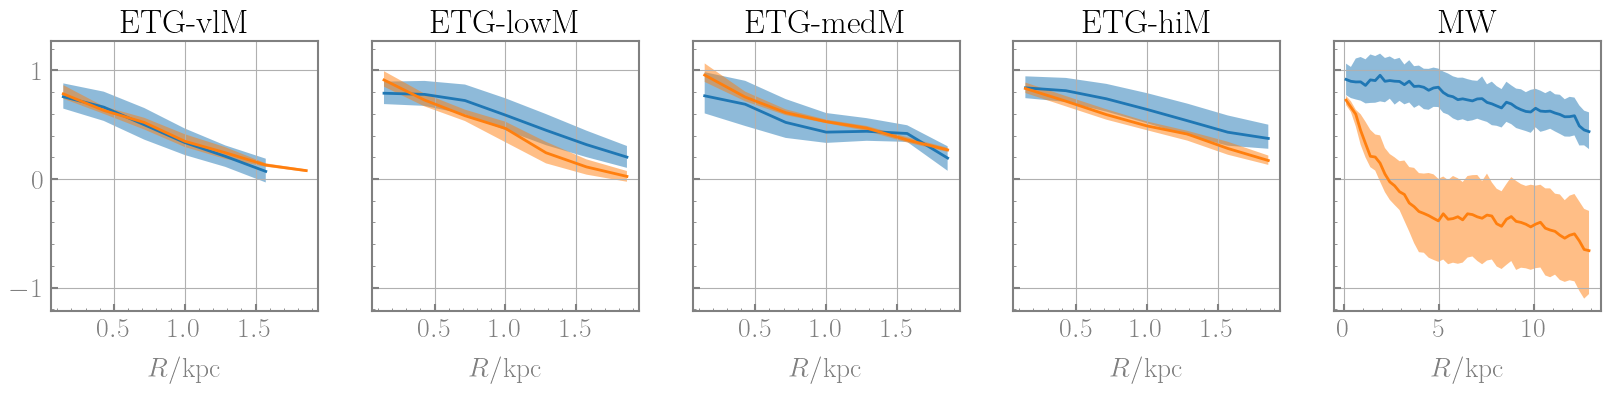

In [18]:
fig, axs = plt.subplots(1, len(tags), figsize=(4*len(tags), 3.5), sharey=True)
for ax, tag, veldisps, veldisps_MLP, Rs, Rs_MLP, xymax in zip(axs, tags, veldisps_gal, veldisps_MLP_gal, Rs_gal, Rs_MLP_gal, xymaxs):
    bins = np.linspace(0., xymax, int(np.rint(xymax/0.25)))
    Rbins = 0.5*(bins[:-1] + bins[1:])

    cnd = (veldisps>0)
    veldisps_med, _, _ = binned_statistic(Rs[cnd], veldisps[cnd], bins=bins, statistic='median')
    veldisps_q1, _, _ = binned_statistic(Rs[cnd], veldisps[cnd], bins=bins, statistic=lambda x: np.percentile(x, 25))
    veldisps_q4, _, _ = binned_statistic(Rs[cnd], veldisps[cnd], bins=bins, statistic=lambda x: np.percentile(x, 75))

    cnd = (veldisps_MLP>0)
    veldisps_MLP_med, _, _ = binned_statistic(Rs_MLP[cnd], veldisps_MLP[cnd], bins=bins, statistic='median')
    veldisps_MLP_q1, _, _ = binned_statistic(Rs_MLP[cnd], veldisps_MLP[cnd], bins=bins, statistic=lambda x: np.percentile(x, 25))
    veldisps_MLP_q4, _, _ = binned_statistic(Rs_MLP[cnd], veldisps_MLP[cnd], bins=bins, statistic=lambda x: np.percentile(x, 75))

    ax.plot(Rbins, np.log10(veldisps_med/1.e5), lw=2)
    ax.fill_between(Rbins, np.log10(veldisps_q1/1.e5), np.log10(veldisps_q4/1.e5), alpha=0.5)

    ax.plot(Rbins, np.log10(veldisps_MLP_med/1.e5), lw=2)
    ax.fill_between(Rbins, np.log10(veldisps_MLP_q1/1.e5), np.log10(veldisps_MLP_q4/1.e5), alpha=0.5)
    
    ax.set_xlabel(r'$R/{\rm kpc}$')
    ax.set_title(tag)
    ax.tick_params(axis='both', direction='in', which='both')
    ax.minorticks_on()
    ax.grid(True)